In [1]:
## Libraries
import numpy as np
import matplotlib.pyplot as plt

## Plot settings
plt.rc('xtick', direction='in', labelsize=14)
plt.rc('ytick', direction='in', labelsize=14)
plt.rc('axes', labelsize=20, titlesize=22)
plt.rc('legend', fontsize=14)

In [2]:
# Generate a list from -x to x including 0
def ss(n):
    pos = [x for x in range(1,n + 1)]
    neg = sorted([-x for x in range(1,n + 1)])
    v = neg + [0] + pos
    return np.array(v)

In [3]:
## Define dimension of 4D cube
dim = 4
v = ss(6)
lv = len(v)

# Create skeleton of the matrix
V = np.zeros((dim, lv**dim))

# Adjust entries as given by matlab code
k = [x for x in range(1, dim+1)]
for i in k:
    V[i-1, :] = np.kron(np.ones((1, lv**(dim - i))), np.kron(v,np.ones((1, lv**(i - 1)))))

# Define U matrix that does the rotation
U = (1/2) * np.array([[-1,0,-1,np.sqrt(2)],[1,np.sqrt(2),-1,0],[-1,0,-1,-np.sqrt(2)],[-1,np.sqrt(2),1,0]])

# Create the rotated matrix V through matri multiplication
V_rot = np.matmul(U,V)

In [4]:
## Now we select the points for the projection 
## This is based on whether or not the points lie inside an octagon when projected on 3rd and 4th dimensions 

# Define an empty list to store lattice points for projection in
z = []

# DOUBLE CHECK WITH ANNE TO REALISE FUNCTION OF THESE TWO
v_ref = np.exp(1j * np.arange(-0.75, 1.25, 0.25) * np.pi)
y_ref = 1/(2*np.sqrt(2)*np.tan(np.pi/8))

# For loop checking and selecting points for aperiodic lattice
k_2 = [x for x in range(1, lv**dim)]
for i in k_2:
    if max(abs((v_ref.conj().T * np.array(V_rot[2, i] + 1j * V_rot[3, i])).real)) <= y_ref + 10**(-8):
        element = V_rot[0, i] + 1j * V_rot[1,i]
        z.append(element)

# Find index of z = 0
index_0 = [i for i in range(len(z)) if abs(z[i]) == 0]
# Calculate the shortest distance and use this as the tile lengths for all vertecies
dists_0 = [abs(z[index_0[0]] - i) for i in z]
tile_len = min([x for x in dists_0 if x > 0])
# Then we calculate the possible jumps of all vertices.
def jump_finder(input_list):
    # Define empty possible jumps
    total_jumps = []
    jump_indices = []
    for i in input_list:
        # Calculate every jump for every point
        jumps = [x for x in input_list if tile_len - 10**(-lv) <= abs(i - x) <= tile_len + 10**(-lv)]
        # Find index of site to which we may jump
        indices = [j for j in range(len(input_list)) for y in jumps if input_list[j] == y]
        # Append to main lists
        total_jumps.append(jumps)
        jump_indices.append(indices)
    return total_jumps, jump_indices
total_jumps, jump_indices = jump_finder(z)

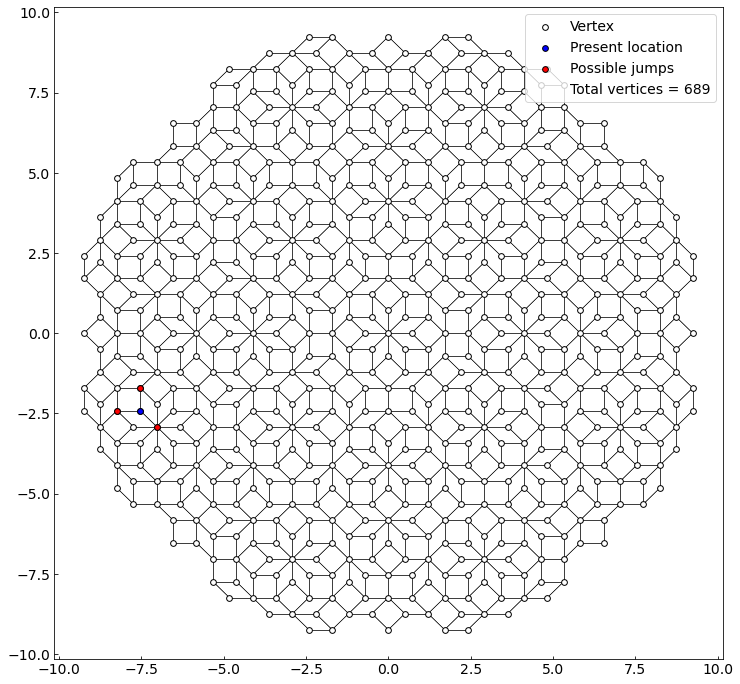

In [5]:
# Define figure
fig, ax = plt.subplots(figsize=(12,12))

# Plot all possible paths between vertices
for i,j in zip(z,total_jumps):
    xs = [w.real for w in j]
    ys = [w.imag for w in j]
    for l,k in zip(xs,ys):
        ax.plot([i.real, l], [i.imag, k], color= 'k', zorder= 1, linewidth= 0.5)

# Extract coordinates in cartesian terms
xs = [w.real for w in z]
ys = [w.imag for w in z]

# Choose index to highlight a specific vertex and its connecting points
#ind_choice = int(len(z)*0.33)
ind_choice = 65

xs_jumps = [w.real for w in total_jumps[ind_choice]]
ys_jumps = [w.imag for w in total_jumps[ind_choice]]

marker_size = 33

ax.scatter(x= xs, y= ys, s= marker_size, facecolor= 'w', edgecolor= 'k', label= "Vertex", linewidth= 1)
ax.scatter(x= xs[ind_choice], y= ys[ind_choice], s= marker_size, facecolor= 'b', edgecolor= 'k', label= "Present location", linewidth= 1)
ax.scatter(x= xs_jumps, y= ys_jumps, s= marker_size, facecolor= 'r', edgecolor= 'k', label= "Possible jumps", linewidth= 1)
ax.plot([],[], linestyle= '', label= "Total vertices = {}".format(len(z)))

ax.legend(loc= 1)

plt.savefig('../Illustrations/hofstadter_AB_tiling.png')
plt.show()


In [6]:
def Hamil_solve(z, B):
    # Define now a skeleton of the Hamiltonian 
    dim_H = len(z)
    H = np.zeros((dim_H, dim_H), dtype= np.complex128)
    k_H = [x for x in range(0, dim_H)]
    # Calculate Peierls phase factor according to the 1st artcle 
    l = tile_len
    phi = B * l**2
    phi_0 = 2 * np.pi
    jump_products = []
    for i, j in zip(z, total_jumps):
        products = [(k.imag - i.imag) * (i.real + k.real) for k in j]
        jump_products.append(products)
    phase_factors = []
    for i, j in zip(z, jump_products):
        phases = [(phi/(2 * l**2)) * k for k in j]
        phase_factors.append(phases)

    # Scaling via J, maybe energy factor
    J = 1
    # Fill out the Hamiltonian according to the psi vector, i.e. the basis chosen through generation of the tiling
    for x, y, z in zip(k_H, jump_indices, phase_factors):
        for k, t in zip(y, z):
            H[x, k] = J * np.exp(1j * t)

    # Now we find the eigenvalues and eigenvectors
    # Note that eigh returns normalized eigenvectors!
    # Note the eigenvectors are arranged in a matrix so eig_vecs[:,i] chooses the i'th column which is the i'th eigenvector
    eig_vals, eig_vecs = np.linalg.eigh(H)
    return eig_vals, eig_vecs

# Calculate eigenvalues for varying B field strength
Bs = np.linspace(0,4*np.pi,50)
eigvals = [Hamil_solve(z,x)[0] for x in Bs]
# Segment the eigenvalues into proper drawable bands
dim_H = len(z)
bands = [x for x in range(0, dim_H)]

eigs_banded = []
for i in bands:
    band = [x[i] for x in eigvals]
    eigs_banded.append(band)

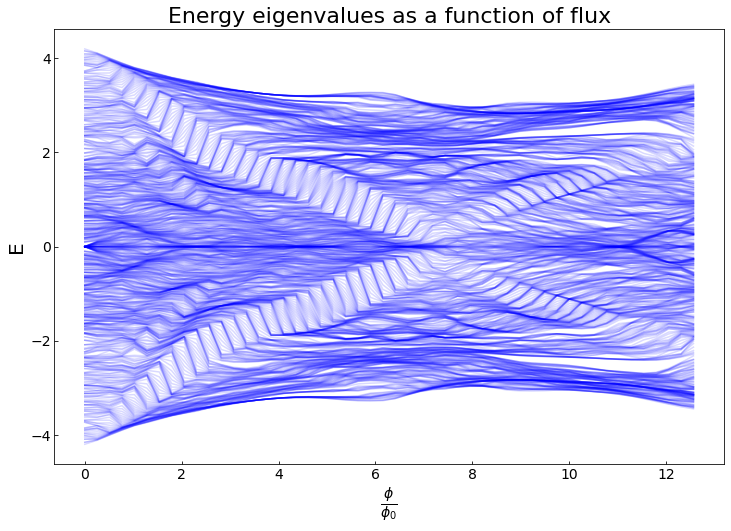

In [7]:
fig, ax = plt.subplots(figsize= (12,8))

for y in eigs_banded:
    ax.plot(Bs,y, color= 'b', alpha= 0.15)

ax.set_title('Energy eigenvalues as a function of flux')
ax.set_xlabel(r'$\frac{\phi}{\phi_0}$')
ax.set_ylabel(r'E')


plt.savefig('../Illustrations/AB_bands.png')
plt.show()

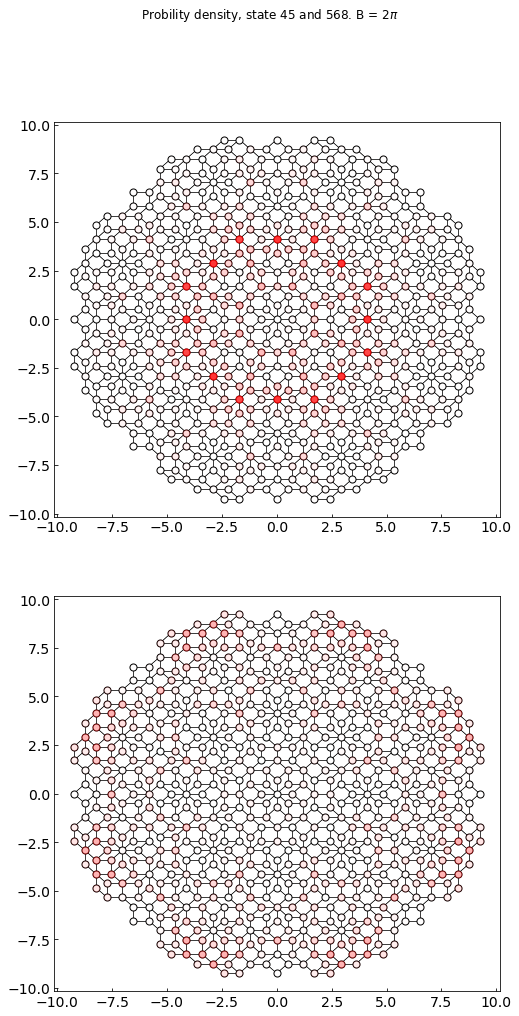

In [11]:
# Take field strength of B= 2pi so that phi/phi0= 0.5
evals_mid, evecs_mid = Hamil_solve(z, 2*np.pi)




fig, ax = plt.subplots(2,figsize= (8,16))

for w, q in zip([0,1], [44,567]):
    # We may multiply every entry of the conjugate with its partner non conjugated since we are working with and orthonormal basis of eigenvectors
    # Normalization stems from eigh, and orthonality from each site being a part of orthogonal basis
    prob_mid = [50*x.real for x in evecs_mid[:,q].conj() * evecs_mid[:,q]]
    # Plot all possible paths between vertices
    for i,j in zip(z,total_jumps):
        xs = [w.real for w in j]
        ys = [w.imag for w in j]
        for l,k in zip(xs,ys):
            ax[w].plot([i.real, l], [i.imag, k], color= 'k', linewidth= 0.5)

    marker_size = 50

    xs = [w.real for w in z]
    ys = [w.imag for w in z]

    # One for skeleton plotting
    ax[w].scatter(x= xs, y= ys, s= marker_size, facecolor= 'w', edgecolor= 'k', label= "Vertex", linewidth= 1, zorder= 2)

    # One for grading in an out
    for i, j, k in zip(xs, ys, prob_mid):
        ax[w].scatter(x= i, y= j, s= marker_size, facecolor= 'r', alpha= k, zorder= 3)

plt.suptitle(r'Probility density, state 45 and 568. B = 2$\pi$')

plt.savefig('../Illustrations/AB_prob_density.png')
plt.show()